<a href="https://colab.research.google.com/github/opencoca/disco-diffusion/blob/main/Antarctic_Captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Caption Generation Demo

By: dzryk (discord, https://twitter.com/dzryk, https://github.com/dzryk)

This notebook provides an image captioning demo that goes along with the antarctic-captions repository (https://github.com/dzryk/antarctic-captions)

In [1]:
!nvidia-smi

Tue Jun 21 00:44:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/dzryk/antarctic-captions.git
%cd antarctic-captions/
!git clone https://github.com/openai/CLIP

Cloning into 'antarctic-captions'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 35), reused 37 (delta 13), pack-reused 0
Unpacking objects: 100% (71/71), done.
/content/antarctic-captions
Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.92 MiB | 22.43 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [3]:
!pip3 install gdown
!pip3 install ftfy
!pip3 install transformers
!pip3 install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.3 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-kvxvlp09
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-

In [4]:
# Download models and cache
!wget -m -np -c -U "eye02" -w 2 -R "index.html*" "https://the-eye.eu/public/AI/models/antarctic-captions/"

--2022-06-21 00:45:34--  https://the-eye.eu/public/AI/models/antarctic-captions/
Resolving the-eye.eu (the-eye.eu)... 162.213.130.6
Connecting to the-eye.eu (the-eye.eu)|162.213.130.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘the-eye.eu/public/AI/models/antarctic-captions/index.html.tmp’

the-eye.eu/public/A     [ <=>                ]     781  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-06-21 00:45:35 (81.9 MB/s) - ‘the-eye.eu/public/AI/models/antarctic-captions/index.html.tmp’ saved [781]

Loading robots.txt; please ignore errors.
--2022-06-21 00:45:37--  https://the-eye.eu/robots.txt
Reusing existing connection to the-eye.eu:443.
HTTP request sent, awaiting response... 404 Not Found
2022-06-21 00:45:37 ERROR 404: Not Found.

Removing the-eye.eu/public/AI/models/antarctic-captions/index.html.tmp since it should be rejected.

--2022-06-21 00:45:39--  https://the-eye.eu/public/A

In [5]:
import argparse
import io
import numpy as np
import torch
import torch.nn as nn
import requests
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from CLIP import clip
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.utils import make_grid

import model
import utils

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [7]:
# Helper functions
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def load_image(img, preprocess):
    img = Image.open(fetch(img))
    return img, preprocess(img).unsqueeze(0).to(device)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def display_grid(imgs):
    reshaped = [F.to_tensor(x.resize((256, 256))) for x in imgs]
    show(make_grid(reshaped))
    
def clip_rescoring(args, net, candidates, x):
    textemb = net.perceiver.encode_text(
        clip.tokenize(candidates).to(args.device)).float()
    textemb /= textemb.norm(dim=-1, keepdim=True)
    similarity = (100.0 * x @ textemb.T).softmax(dim=-1)
    _, indices = similarity[0].topk(args.num_return_sequences)
    return [candidates[idx] for idx in indices[0]]

def loader(args):
    cache = []
    with open(args.textfile) as f:
        for line in f:
            cache.append(line.strip())
    cache_emb = np.load(args.embfile)
    net = utils.load_ckpt(args)
    net.cache = cache
    net.cache_emb = torch.tensor(cache_emb).to(args.device)
    preprocess = clip.load(args.clip_model, jit=False)[1]
    return net, preprocess
    
def caption_image(path, args, net, preprocess):
    captions = []
    img, mat = load_image(path, preprocess)
    table, x = utils.build_table(mat.to(device), 
                          perceiver=net.perceiver,
                          cache=net.cache,
                          cache_emb=net.cache_emb,
                          topk=args.topk,
                          return_images=True)
    table = net.tokenizer.encode(table[0], return_tensors='pt').to(device)
    out = net.model.generate(table,
                             do_sample=args.do_sample,
                             num_beams=args.num_beams,
                             temperature=args.temperature,
                             top_p=args.top_p,
                             num_return_sequences=args.num_return_sequences)
    candidates = []
    for seq in out:
        candidates.append(net.tokenizer.decode(seq, skip_special_tokens=True))
    captions = clip_rescoring(args, net, candidates, x[None,:])
    for c in captions[:args.display]:
        print(c)
    display_grid([img])
    return captions

In [8]:
# Settings
filedir='the-eye.eu/public/AI/models/antarctic-captions/'
args = argparse.Namespace(
    ckpt=f'{filedir}/-epoch=05-vloss=2.163.ckpt',
    textfile=f'{filedir}/postcache.txt',
    embfile=f'{filedir}/postcache.npy',
    clip_model='ViT-B/16',
    topk=10,
    num_return_sequences=1000,
    num_beams=1,
    temperature=1.0,
    top_p=1.0,
    display=5,
    do_sample=True,
    device=device
)

In [9]:
# Load checkpoint and preprocessor
net, preprocess = loader(args)

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 250MiB/s]


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/971M [00:00<?, ?B/s]

In [34]:
# Images
img = 'https://64.media.tumblr.com/c989d03b66ec83957d2297e8f1c05573/tumblr_nza2pvHPQC1r9eqx3o3_1280.jpg'
img2 = 'https://64.media.tumblr.com/0ea2aa1cdb84c9245fbfdd5c9b295b12/tumblr_o91voyXQIN1r9eqx3o1_1280.jpg'
img3 = 'https://64.media.tumblr.com/ace4cd48c83a739e1d74da5c8b2ac063/042953c6aae46481-da/s1280x1920/12bc18c239d11c369c171d358198e50efe17f30c.jpg'
img4 = 'https://64.media.tumblr.com/b14798146319041bde4576201e058712/042953c6aae46481-b3/s1280x1920/f414d6b3ad97226bb37cc73ae646b0ce79b1fbd4.jpg'
img5 = 'https://64.media.tumblr.com/8012bdb879282ea0d06c71dc3d1f60fd/tumblr_niemnfmPgi1r9eqx3o2_1280.jpg'
img6 = 'https://64.media.tumblr.com/f114ebcf2a3c2c0d9885158572951ddd/tumblr_oug6f9fcAM1r9eqx3o1_1280.png'
img7 = 'https://64.media.tumblr.com/02c15a8878140accd34446e93a2ced9d/tumblr_oug6f9fcAM1r9eqx3o2_r1_1280.jpg'
img8 = 'https://images.unsplash.com/photo-1530025809667-1f4bcff8e60f?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=3640&q=80'
img9 = 'https://images.unsplash.com/photo-1587162146766-e06b1189b907?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2325&q=80'
img10 = 'https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80'
img11 = 'https://images.unsplash.com/photo-1621981386829-9b458a2cddde?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2100&q=80'
img12 = 'https://thumbs.dreamstime.com/b/toronto-sign-nathan-phillips-square-view-night-canada-121955940.jpg'

a large building with concrete walls and a large metal pole is in the background
A woman playing an Xbox game in an empty building.
A city with no houses on a street beside a concrete building with an old train running
There is an orange sign hanging beside an unused building near cars.
This is a scene of a city park in front of an abandoned building


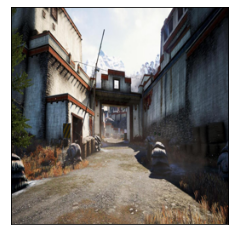

In [11]:
# Generate captions! Running multiple times will give different results.
# If you get a GPU memory error, decrease 'num_return_sequences'. This will impact caption quality.
captions = caption_image(img, args, net, preprocess)

A harbor harbor with water, people, and seals in it. 
A picture of a large harbor filled with animals and surfers.
A dock with boats and a harbor with seals, fish, and ducks.
a colorful and colorful harbor is surrounded by seagulls and white sea otters
A dock filled with marine animals by the water and sea.


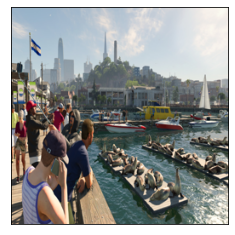

In [12]:
captions = caption_image(img2, args, net, preprocess)

A beautiful forest covered in trees forts and bugs.
A large, brown creature stands at the base of a tree.  
A giant tree that is full of plants with vegetation and plants.
A tall growing tree with huge red plants and white bird nests.
A man stands in a tall, dark place with tall trees and moss.


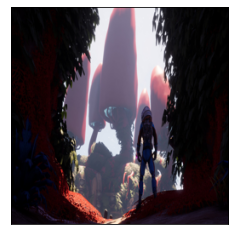

In [24]:
captions = caption_image(img3, args, net, preprocess)

two people race racing through woodland, playing a video game.
Two male players climbing over a mountain wall while riding powergliders.
A player and women riding in the grasses holding some powergliders. 
People are riding around a large island with animals in it. 
A group of adults are playing games in a jungle while a person rides a large white


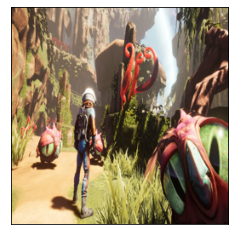

In [26]:
captions = caption_image(img4, args, net, preprocess)

A truck sitting in a container train on it's cab with a passenger area. 
A large boxcar full of freight on the tracks.
A freight car is parked in front of a station in the parking lot of a big
a truck and boxcar sitting on the track in a parking lot
A truck with many empty seats on the side of a freight train.


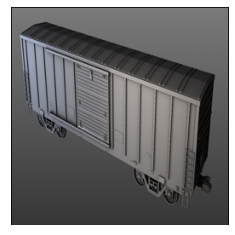

In [28]:
captions = caption_image(img5, args, net, preprocess)

A large ship with a space station in it with some people standing next to it.
A large ship in a shipyard filled with various parts of a large space ship.
A large spaceship that is docking at a ship docks.
a large spaceship building with a huge number of crew in it 
A large ship with multiple spaceships that are docking in the harbor.


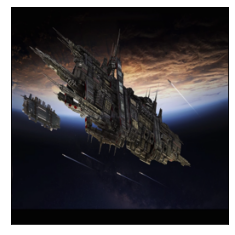

In [33]:
captions = caption_image(img6, args, net, preprocess)

An image of a peaceful landscape in the forest.  
A forest with trees hanging over a river and a scenic view of a mountain range.
a scenic scene with a mountain range and trees and trees
A picture of a forested valley with tall trees, and foliage over a stream.
A mountain view scene with forest and a forest area next to a mountain.


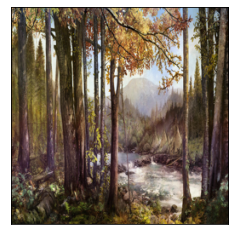

In [35]:
captions = caption_image(img7, args, net, preprocess)

A canada flag that sits alongside a yellow and white airplane.
The yellow and white Canadian flag sits on top of a plane.
The red flag of Canada sits on top of a airplane in the sky.
a close up of a Canadian flag flying above an airplane on top of a building
a Canadian flag of a large airplane above the side of a lake 


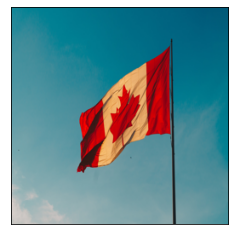

In [18]:
captions = caption_image(img8, args, net, preprocess)

A view of Manhattan from above that consists of busy streets and buildings.
Manhattan and NY are in a city skyline with a lot of buildings along the water
A view of New York City that includes buildings on both sides of an ocean.
A view of downtown New York City surrounded by tall buildings and the river.
A view of New York City with very tall buildings and people in them on a sunny


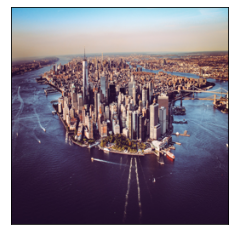

In [19]:
captions = caption_image(img9, args, net, preprocess)

A red candle sitting on top of a desk with a board filled with colorful stock market
A couple of blue lines are formed on a picture window of a stock of stocks.
A stock market index is displayed next to the blue candlestone. 
a number of stocks are listed on a screen on an exchange
A group of stocks are trading on a blue screen of a red building.


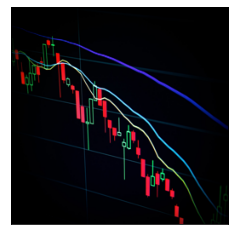

In [20]:
captions = caption_image(img10, args, net, preprocess)

A bag of money on a counter with a sign reading "LOOK FOR EUR
A close up of dollars and euros.
a piece of paper holding both euros and dollars in a bank account and banknote 
A bank note on a table containing Euros, cash and dollars.
A large amount of euro and British dollars are on a table.


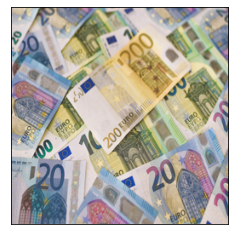

In [21]:
captions = caption_image(img11, args, net, preprocess)

The city of Toronto lit up with a glowing neon neon sign.
A neon sign with the name "Toronto" light up at night.
The City of Toronto is lit up by one of its many neon signs. 
A large number of neon sign are shown in the city of Toronto 
A large white sign with a blue and red light on it that says "Toronto".


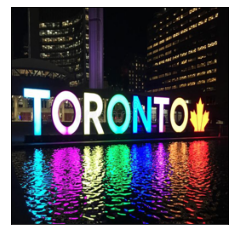

In [22]:
captions = caption_image(img12, args, net, preprocess)